In [78]:
from pathlib import Path

import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.notebook import tqdm
from collections import namedtuple

from eval import read_run_dir
from new_eval import new_get_run_metrics, get_config, baseline_data, LoadInfo, filter_runs
from plot_utils import basic_plot, basic_plot2
from typing import List

%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

#models_dir = Path("../models")
device = "cpu" # Set to "cuda" if needed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
def plot_collection(load_info_collection: List[LoadInfo], title: str, device: str = "cuda", yhigh_lim: float = float('inf'), baselines: List[str] = None, saveas: Path = None):
    metrics = {}
    for path, step, alt_path, alternative_pretrained_dir, alternative_name, name_addon in load_info_collection:
        conf = get_config(path / "config.yaml")
        name = alternative_name if alternative_name != "" else conf.wandb.name + "/" + conf.training.task + name_addon

        if alternative_pretrained_dir is not None:
            print("Alternative pretrained model dir: ", alternative_pretrained_dir)
            conf.model.pretrained_model_dir = str(alternative_pretrained_dir)

        if alt_path is not None:
            conf.training = get_config(alt_path).training

        print(conf.training)

        #conf.training.curriculum.points.end = 31
        #conf.training.curriculum.points.start = 31

        #print(conf.model)

        metrics[name] = new_get_run_metrics(conf, path, step=step, include_noise=False, device=device)

    baselines_names = {'ridge_chebyshev_11': 'Chebyshev Ridge 11', 'chebyshev_11': 'Chebyshev 11'} #'ridge_chebyshev_5']) # "chebyshev_5"
    if baselines is not None:
        train_conf_path = load_info_collection[0].alternative_train_conf_path if load_info_collection[0].alternative_train_conf_path is not None else load_info_collection[0].path / "config.yaml"
        baseline_mets = baseline_data(train_conf_path, device=device, include_noise=False)
        print(baseline_mets.keys())
        metrics.update({baselines_names[key]: baseline_mets[key] for key in baselines if key in baseline_mets})
    
    _, ax = basic_plot2(metrics, yhigh_lim=yhigh_lim)
    ax.set_title(title)
    #plt.tight_layout()
    if saveas is not None:
        plt.savefig(saveas+".pdf", format="pdf")
    #plt.tight_layout()
    plt.show()

Munch({'batch_size': 64, 'curriculum': Munch({'deg': Munch({'end': 11, 'inc': 0, 'interval': 500001, 'start': 11}), 'dims': Munch({'end': 1, 'inc': 1, 'interval': 2000, 'start': 1}), 'points': Munch({'end': 31, 'inc': 1, 'interval': 1000, 'start': 31})}), 'data': 'uniform', 'keep_every_steps': 100000, 'learning_rate': 5e-05, 'num_tasks': None, 'num_training_examples': None, 'resume_id': None, 'save_every_steps': 1000, 'task': 'chebyshev_kernel_linear_regression', 'task_kwargs': Munch({'basis_dim': 11, 'different_degrees': True, 'fixed_coeffs': 0, 'highest_degree': 11, 'lowest_degree': 1, 'scale': 1.0}), 'train_steps': 1600000})
Device: cpu
dict_keys(['chebyshev_11', 'ridge_chebyshev_11'])


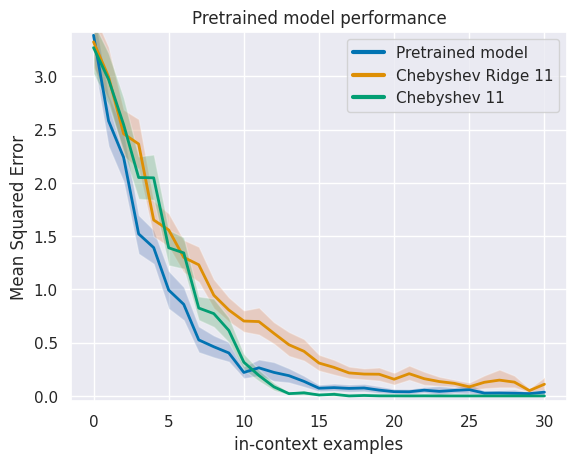

In [80]:
# Just pretrained model performance
pos_dir = Path("../pos_models")

load_collection = [
    LoadInfo(path=pos_dir / "base_model", step=-1,
            alternative_train_conf_path=pos_dir / "base_model" / "short_config.yaml",
            alternative_name="Pretrained model")
]

plot_collection(load_collection, title="Pretrained model performance", device=device, baselines=['ridge_chebyshev_11', "chebyshev_11"], saveas="figs/proof_of_concept")
